In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

seed = 125396749
n = 15
m = 85
speeds = [105]
chargers = list(range(1, 6))
scale = (1e6, 1e6)

graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers,
)

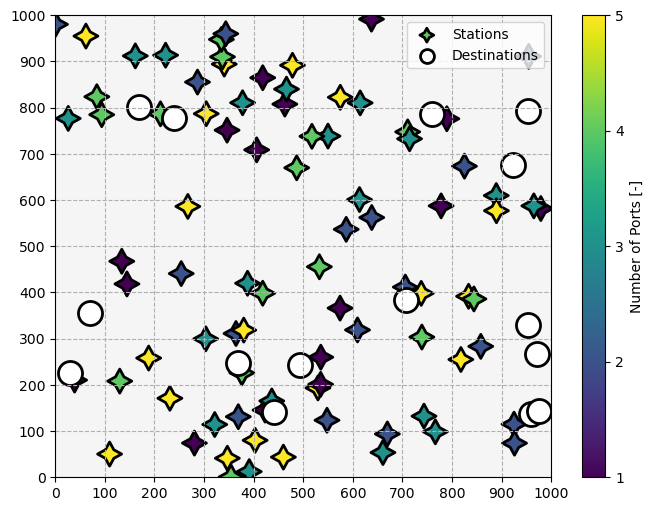

In [3]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [n for n in graph.nodes if 'destination' in n]
stations = [n for n in graph.nodes if 'station' in n]

destinations = src.graph.subgraph(graph, destinations)
stations = src.graph.subgraph(graph, stations)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 300,
        'ec': 'k',
        'lw': 2,
        'marker': (4, 1, 0),
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
        'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(
   stations, ax = ax, **kw,
)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'fc': 'white',
        'ec': 'k',
        'lw': 2,
        'zorder': 1,
        'label': 'Destinations',
    },
}

src.figures.plot_graph(
   destinations, ax = ax, **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend(loc = 1)

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_number_chargers.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [89]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .95,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

In [90]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (0, .1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.8894 seconds
s-rta: 2.4582


In [91]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    # print(path)

    for n in path:

        node = graph._node[n]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

srtad = src.routing.specific_road_trip_accessibility(
    values, field = 'distance',
    expectation = lambda x: src.routing.super_quantile(x, (.9, 1))
) / 1000

n_chargers, n_stations, n_chargers / n_stations, srtad

(120, 31, 3.870967741935484, 558.8267626340786)

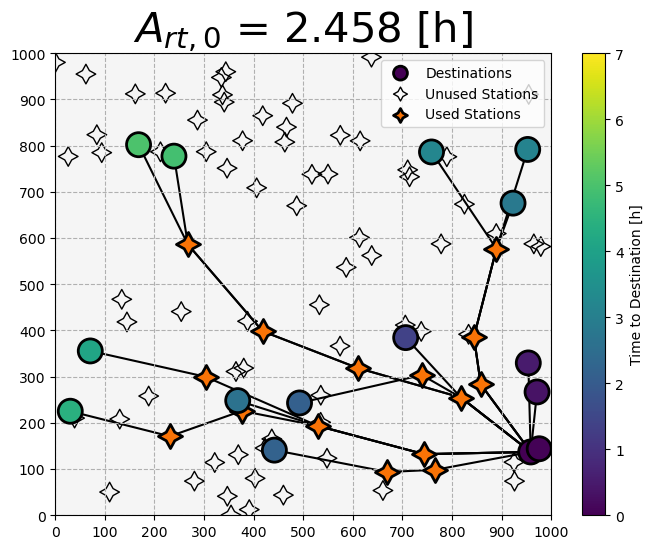

In [56]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    # values = {k: v['time'].mean() / 3600 for k, v in values.items()},
    values = {k: super_quantile(v['time'], (0, .1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_aggressive.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [92]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.9, 1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')
srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (.9, 1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.9449 seconds
s-rta: 3.4475


In [93]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    # print(path)

    for n in path:

        node = graph._node[n]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

srtad = src.routing.specific_road_trip_accessibility(
    values, field = 'distance',
    expectation = lambda x: src.routing.super_quantile(x, (.9, 1))
) / 1000

n_chargers, n_stations, n_chargers / n_stations, srtad

(133, 31, 4.290322580645161, 578.50507109892)

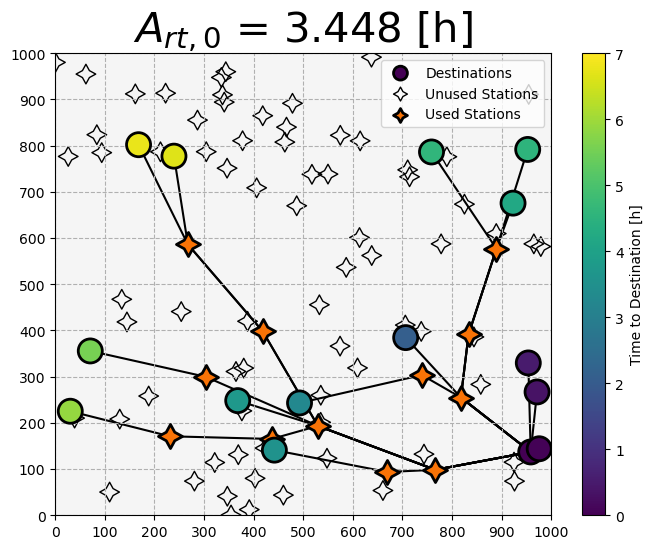

In [58]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    # values = {k: v['time'].mean() / 3600 for k, v in values.items()},
    values = {k: super_quantile(v['time'], (.9, 1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_cautious.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [99]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .75,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

In [100]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')
srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (0, .1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.7714 seconds
s-rta: 2.6201


In [102]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    # print(path)

    for n in path:

        node = graph._node[n]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

srtad = src.routing.specific_road_trip_accessibility(
    values, field = 'distance',
    expectation = lambda x: src.routing.super_quantile(x, (0, 1))
) / 1000

n_chargers, n_stations, n_chargers / n_stations, srtad

(130, 32, 4.0625, 575.9469460885962)

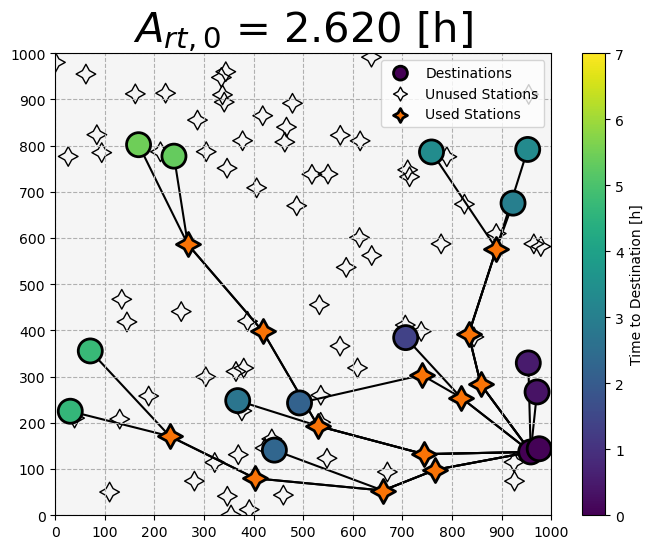

In [35]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    values = {k: super_quantile(v['time'], (0, .1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_aggressive.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [103]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.9, 1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')
srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (.9, 1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.9514 seconds
s-rta: 5.0017


In [104]:
n_chargers = 0
n_stations = 0

for path in paths.values():
    # print(path)

    for n in path:

        node = graph._node[n]

        if node.get('n_dcfc', 0) > 0:

            n_stations += 1
            n_chargers += node['n_dcfc']

srtad = src.routing.specific_road_trip_accessibility(
    values, field = 'distance',
    expectation = lambda x: src.routing.super_quantile(x, (0, 1))
) / 1000

n_chargers, n_stations, n_chargers / n_stations, srtad

(120, 32, 3.75, 574.9526592283837)

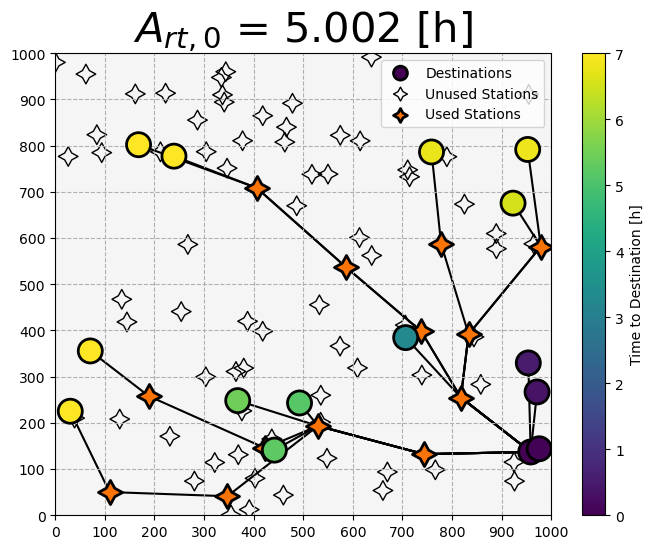

In [37]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    # values = {k: v['time'].mean() / 3600 for k, v in values.items()},
    values = {k: super_quantile(v['time'], (.9, 1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_cautious.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [44]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .95,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

In [45]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')

srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (0, 1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.8732 seconds
s-rta: 2.8289


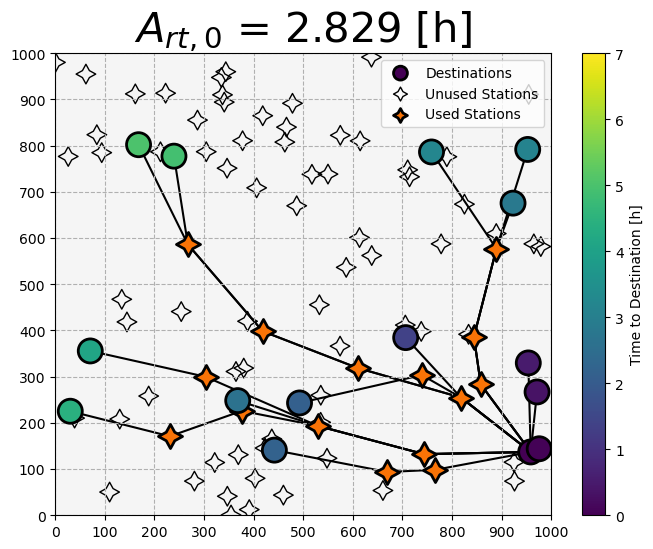

In [46]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    # values = {k: v['time'].mean() / 3600 for k, v in values.items()},
    values = {k: super_quantile(v['time'], (0, .1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_aggressive_n.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [47]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.9, 1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')
srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (0, 1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.9240 seconds
s-rta: 2.8435


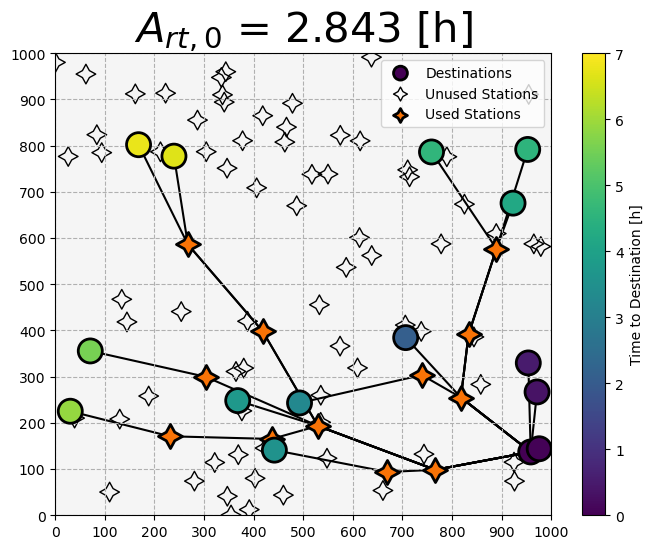

In [48]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    # values = {k: v['time'].mean() / 3600 for k, v in values.items()},
    values = {k: super_quantile(v['time'], (.9, 1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_high_reliability_cautious_n.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [49]:
'''
Adding station objects
'''
deep_reload(src)

kw = {
    'cases': 100,
    'reliability': .75,
    'rng': np.random.default_rng(seed),
    'base_delay': 300,
}

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], **kw,
        )

In [50]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (0, .1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')
srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (0, 1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.7785 seconds
s-rta: 3.4676


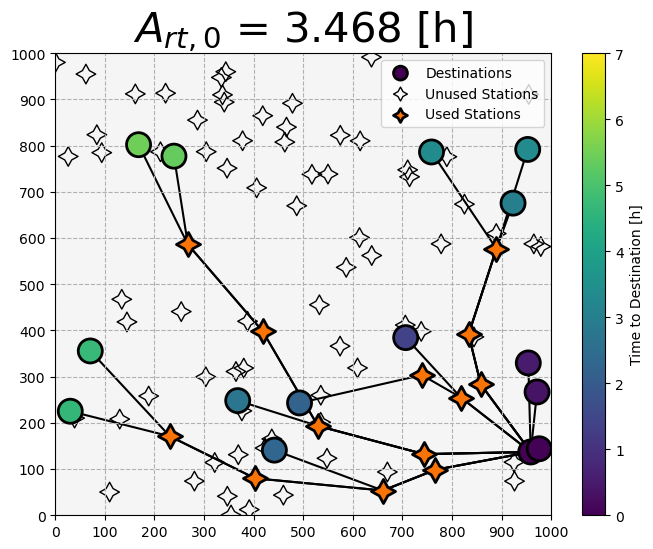

In [51]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    values = {k: super_quantile(v['time'], (0, .1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_aggressive_n.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [52]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    cases = 100,
    capacity = 40 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.9, 1),
)

kw = {
    'objective': vehicle,
    'return_paths': True,
    'method': 'bellman',
    'destinations': [n for n in graph.nodes if 'destination' in n],
}

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'], **kw,
)


print(f'Executed in {time.time() - t0:.4f} seconds')
srta = src.routing.specific_road_trip_accessibility(
        values, expectation = lambda x: src.routing.super_quantile(x, (0, 1))
) / 3600

print(f's-rta: {srta:.4f}')

Executed in 0.9339 seconds
s-rta: 3.4603


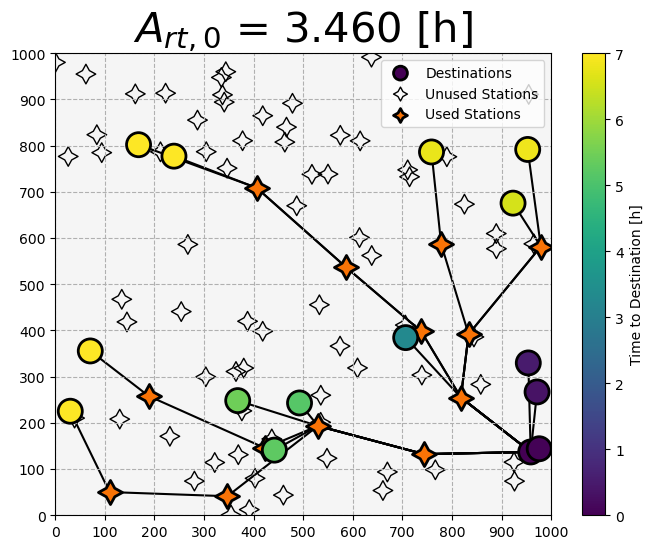

In [53]:
deep_reload(src)
from src.routing import super_quantile

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

kw['destinations_kw']['scatter']['vmax'] = 7
kw['stations_used_kw']['scatter']['fc'] = 'xkcd:orange'

src.figures.plot_route_tree(
    ax, graph,
    # values = {k: v['time'].mean() / 3600 for k, v in values.items()},
    values = {k: super_quantile(v['time'], (.9, 1)) / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

ax.set_title(r'$A_{rt,0}$' + f' = {srta:.3f} [h]', fontsize = 30)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_low_reliability_cautious_n.png',
    bbox_inches = 'tight',
    dpi = 300,
)